In [73]:
import cv2
# import pytesseract
import pandas as pd
import numpy as np
import segyio
from segyio import TraceField ,BinField
# import matplotlib.pyplot as plt
# from segpy.dataset import Dataset
import logging
from pathlib import Path
from scipy import signal
import toml
from PIL import Image, ImageOps
import datetime 
logger = logging.getLogger(__name__)
import os
from scipy.signal import butter, lfilter, freqz

from image2segy_utils import *
from seisimage_utils import *

import matplotlib.pyplot as plt
%matplotlib inline
datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Palawan\undone\\'
files=['0047_1973_West Palawan_2D_Repro1974_Time_Unmig_P-5_crop.png',
#        '00018_1966_SABAH_2D_Repro_1966_Time_Unmigrated_ 1A _crop.png'
#       'test.png',
#        '0128_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ B-129_crop.png'
      ]

In [74]:
for f in files:
    print("'{}':{}'strc':1,'ntrace':4316,'trange':[0,6]{},".format(f[:4],'{','}'))

'0047':{'strc':1,'ntrace':4316,'trange':[0,6]},


In [84]:

file=files[-1]
key=2
timeranges={'0047':[0,6],'108':[0,6],'109':[0,6],'111':[0,6],'116':[0,6],'117':[0,6],'119':[0,6],'0254':[0,5]}
filekey=file.split('_')[0]

fileproperties={'0047':{'strc':1,'ntrace':4316,'trange':[0,6],'0001':{'strc':1,'ntrace':620,'trange':[0,2.5]},},
}
# fileproperties={'0006':{'strc':1,'ntrace':2904,'trange':[0,4],'0001':{'strc':1,'ntrace':620,'trange':[0,2.5]},},
# }
# filekey
fileproperties

{'0047': {'strc': 1,
  'ntrace': 4316,
  'trange': [0, 6],
  '0001': {'strc': 1, 'ntrace': 620, 'trange': [0, 2.5]}}}

In [38]:
datafolder+file

'D:\\Ameyem\\Bhugarbho\\JOGMEC\\SeismicSection\\Thailand\\undone\\\\0002_Unknown_Gulf of Thailand_2D_Repro_1993_Time_PostSTM_Line 2_crop.png'

In [77]:
image = cv2.imread(datafolder+file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clipped_im=gray#[:1000,:1000]

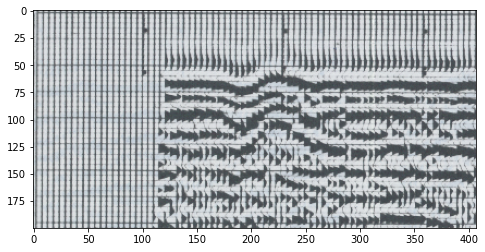

In [78]:
# clipped_im=gray[:1000,:1000]
fig=plt.figure(figsize=(16,4))
plt.imshow(image[:ch,:cw,:])

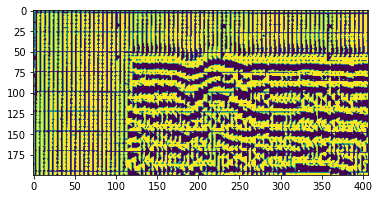

In [79]:
selim=clipped_im[:ch,:cw]
horizontalsize=30
horizontal = cv2.adaptiveThreshold(selim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
plt.imshow(horizontal)

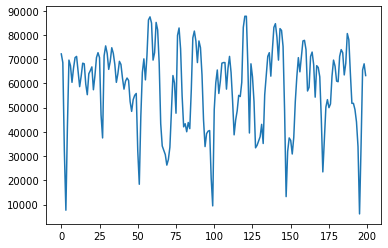

In [80]:
selim=horizontal.astype(float)

# selim[selim<=127.0]=1
# selim[selim>127.0]=0
res=selim.sum(axis=1)
plt.plot(res)

In [71]:
clipped_im=gray.copy()

(array([86, 87, 88, 89, 90, 91, 92, 93], dtype=int64), 90)

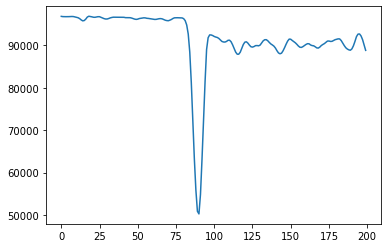

In [72]:
clipped_im.shape
h,w=clipped_im.shape
ch,cw=int(h/10),int(w/55)
if ch<200 or cw<200:
    if ch<200:
        ch=200
    if cw<200:
        cw=200
selim=clipped_im[:ch,:cw]
# horizontalsize=30
# horizontal = cv2.adaptiveThreshold(selim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
# rows,cols = horizontal.shape
# # selim=horizontal.astype(float)
# # horizontalsize = 30
# horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,2))
# # horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
# horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))
# selim=horizontal.astype(float)

# selim[selim<=127.0]=1
# selim[selim>127.0]=0
res=selim.sum(axis=1)
plt.plot(res)
mindx=np.argmin(res)
checkval=np.mean(res)-2*np.std(res)
idxs=np.where(res<checkval)[0]
idxs,mindx

In [67]:
idxs,mindx

(array([], dtype=int64), 78)

In [48]:
zerotlineid=findHorlineIndex(clipped_im,horizontalsize=30)
# if zerotlineid==0:
#     zerotlineid=findHorlineIndex(clipped_im,horizontalsize=10)
#     if zerotlineid==0:
#         zerotlineid=findHorlineIndex_alt(clipped_im,horizontalsize=10)
# try:
#     self.colnumbers,shifts2bapplied=getColumnShifts(clipped_im,zerotlineid)
#     self.shifts2bapplied=getCleanedCurve(shifts2bapplied,returnsmooth=return_smooth)    
#     straightImage=getStraightenedImage(cv2im,self.colnumbers+idxes[0],self.shifts2bapplied)
#     self.load_cv2im( straightImage,isgrey=False)
#     print('Done alignment....')
# except:
#     msg=QMessageBox()
#     msg.setText('Error in alignement')
#     msg.exec_()

In [49]:
zerotlineid

0

In [86]:
def gethorizontalLineFilter(hf_data,sgray):
    # hf_data[hf_data>0]=0
    # hf_data[hf_data>-0.05]=0
    # hf_data[hf_data<=-0.05]=1

    nmin=np.mean(hf_data[hf_data<0])
    hf_data[hf_data>nmin]=0
    hf_data[hf_data<=nmin]=1
    
    ids=np.where(hf_data==1)
    difids=np.diff(ids)
    difids[difids>1]
    spike_interval=int(np.nanmedian(difids[difids>1]))
    # ,np.mean(difids[difids>1])
    _,spikewidths=np.where(difids>1)
    spikewidth=int(np.median(np.diff(spikewidths)))
#     spike_interval,spikewidth
    halfspikew=int(spikewidth/2)
    x = np.arange(-halfspikew+1, 1,1)
    print(halfspikew)
    mfilter=x**2/40+0.01
    if len(mfilter)*2==spikewidth:
        mfilter=np.array([*mfilter,*mfilter[::-1]])
    else:
        mfilter=np.array([*mfilter,mfilter[-1],*mfilter[::-1]])
    smallfilter=np.append([1]*spike_interval,mfilter)
    times=int(len(sgray)/len(smallfilter))
    fullfilter=np.array([*smallfilter]*(times+1))[:len(sgray)]
    return fullfilter
for file in files:
    filekey=file.split('_')[0]
    ntrace=fileproperties[filekey]['ntrace']
    ntrc=ntrace
    strc=fileproperties[filekey]['strc']
    etrc=strc+ntrc
    stime,etime=np.array(fileproperties[filekey]['trange'])*1000
    strc,etrc,ntrc,stime,etime

    image = cv2.imread(datafolder+file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sgray=gray.sum(axis=1)

    print(file,gray.shape)

    sgray=gray.sum(axis=1)
    cutoff = 30.0
    bestcases={'':6}
    for key in bestcases:
        case=bestcases[key]

    # for case in range(1,7):
        print('Case: ',case)
        crude_hor_filter,useStepOp,useHorfilter=getDirections(case)
        #Horizontal filter calculation to remove horizontal lines
        twt=list(range(len(sgray)))
        lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)
        useHorfilter=True
        crude_hor_filter=False
        if useHorfilter:
            if not crude_hor_filter:
                hlfilter=gethorizontalLineFilter(hf_data,gray) #median gap found and kept lo values to nullify horizontal line
                hlfilter[hlfilter<=0.5]=0.5
                print('hlfilter')
            else:
                hlfilter=getHorizontalRawFilter(hf_data) #filter generate with crude way, line gaps are filled with 0.1 values

        mthresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        #     traces=img2rawtrace(clipped_im,stime,etime,ntrc)
        traces=img2rawtrace(mthresh,stime,etime,ntrc)
        traces=successiveDeduction(traces,ntraces=200)

        # fig=plt.figure(figsize=(18,16))
        # plt.imshow(traces.T)


        # plt.plot(traces[:,int(for50msec)])

        #Operator for smooth trace
        trcno=200
        mtrc=traces[trcno]


        if useHorfilter:
            mtrc=mtrc*hlfilter

        if not useStepOp:
            op=getOperator(mtrc,old=False)
        else:
            op=getOperatorStep(mtrc)


        # Filter or not and make resultant traces as float64 type
        tracet=traces.shape[1]
        actualt=etime
        tracetpermsec=tracet/etime
        for50msec=tracetpermsec*30
        traces[:,:int(for50msec)]=traces[:,:int(for50msec)]*0.1

        if useHorfilter:
            result=(np.array(traces)*hlfilter*1000).astype(np.float64)
        else:
            result=(np.array(traces)*1000).astype(np.float64)

        print(traces.shape,result.shape)
        trange=np.arange(stime,etime+1,2).astype(int)
        proctrcs= getOpProcTraces(result,op,trange)
    #     filttrcs=np.array(proctrcs)
        filttrcs= getLowPassfilteredTraces(proctrcs,cutoff = cutoff )



        inputdict=dict(dstpath=datafolder+file.replace('_crop.png','')+'_raw{}.sgy'.format(key),srcpath='bak_test2.sgy',
                   mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)

        status=saveAsSegy(filttrcs.T,inputdict=inputdict,delrt=2,strc=strc,setimes=[stime,etime])
        if status:    
            print('Done export..',inputdict['dstpath'])
        else:
            print('Export incomplete..')
#         fig=plt.figure(figsize=(16,16))
#     #     plt.imshow(filttrcs.T[:800,-800:])
#         plt.imshow(filttrcs.T)
#         plt.show()

0047_1973_West Palawan_2D_Repro1974_Time_Unmig_P-5_crop.png (2404, 23179)
Case:  6
0


IndexError: index -1 is out of bounds for axis 0 with size 0

In [101]:
# lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)

# nmin-1*std,nmin
mfilter

array([], dtype=float64)

In [111]:
lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)
nmin=np.mean(hf_data[hf_data<0])
std=np.std(hf_data[hf_data<0])
nmin=nmin-1*std
# hf_data[hf_data>0]=0
# hf_data[hf_data>-0.05]=0
# hf_data[hf_data<=-0.05]=1
hf_data[hf_data>nmin]=0
hf_data[hf_data<=nmin]=1
ids=np.where(hf_data==1)
difids=np.diff(ids)
difids[difids>1]
spike_interval=int(np.nanmedian(difids[difids>1]))
# ,np.mean(difids[difids>1])
_,spikewidths=np.where(difids>1)
spikewidths
spikewidth=int(np.median(np.diff(spikewidths)))
spikewidth

1

In [114]:
np.diff(spikewidths)

array([3, 8, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 2, 4, 1, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 4, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1],
      dtype=int64)

In [110]:
np.nanmedian(difids[difids>1])
np.where(difids>1)
spikewidth=int(np.median(np.diff(spikewidths)))
spikewidth

1

In [100]:


#     spike_interval,spikewidth
halfspikew=int(spikewidth/2)
x = np.arange(-halfspikew+1, 1,1)
print(halfspikew)
mfilter=x**2/40+0.01
if len(mfilter)*2==spikewidth:
    mfilter=np.array([*mfilter,*mfilter[::-1]])
else:
    mfilter=np.array([*mfilter,mfilter[-1],*mfilter[::-1]])
smallfilter=np.append([1]*spike_interval,mfilter)
times=int(len(sgray)/len(smallfilter))
fullfilter=np.array([*smallfilter]*(times+1))[:len(sgray)]
plt.plot(twt,hf_data)

0


IndexError: index -1 is out of bounds for axis 0 with size 0

-0.004665585528642878 0.00378505136270376


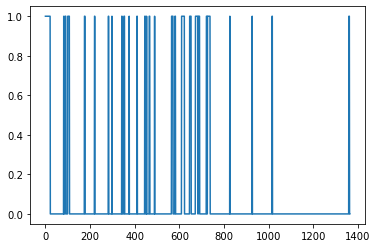

In [32]:
lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)
# twt,
nmin=np.mean(hf_data[hf_data<0])
nmax=np.mean(hf_data[hf_data>0])
print(nmin,nmax)
# # gethorizontalLineFilter(hf_data,gray)
# hf_data
# hf_data[hf_data>0]=0
hf_data[hf_data>nmin]=0
hf_data[hf_data<=nmin]=1
plt.plot(twt,hf_data)
# ids=np.where(hf_data==1)
# ids
# difids=np.diff(ids)
# difids[difids>1]
# spike_interval=int(np.nanmedian(difids[difids>1]))

In [ ]:
# filename=self.bigim_canvas.file_path[:-4] +'_raw.sgy'
ntrace=int(self.trace_count_edit.text())
ntrc=ntrace
strc=1
# etrc=strc+ntrc+
stime,etime=0,float(self.total_time_edit.text())*1000
try:
    gray = cv2.cvtColor(self.PixIm_to_CV2Im(self.crop_image), cv2.COLOR_BGR2GRAY)
except:
    gray=np.zeros((2,2))
    msg=QMessageBox()
    msg.setText('Crop image first \n')
    msg.exec_()
    return 0

sgray=gray.sum(axis=1)


cutoff = 30.0
bestcases={'':6}
# for key in bestcases:
#     case=bestcases[key]
case=bestcases['']
print('Case: ',case)
crude_hor_filter,useStepOp,useHorfilter=getDirections(case)
#Horizontal filter calculation to remove horizontal lines
twt=list(range(len(sgray)))
lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)
useHorfilter=True
crude_hor_filter=False
if useHorfilter:
    if not crude_hor_filter:
        hlfilter=gethorizontalLineFilter(hf_data,gray) #median gap found and kept lo values to nullify horizontal line
        hlfilter[hlfilter<=0.5]=0.5
        print('hlfilter')
    else:
        hlfilter=getHorizontalRawFilter(hf_data) #filter generate with crude way, line gaps are filled with 0.1 values

mthresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#     traces=img2rawtrace(clipped_im,stime,etime,ntrc)
traces=img2rawtrace(mthresh,stime,etime,ntrc)
# traces=successiveDeduction(traces,ntraces=200)
#Operator for smooth trace
trcno=200
if trcno> len(traces): trcno=int(len(traces)/2)
mtrc=traces[trcno]


if useHorfilter:
    mtrc=mtrc*hlfilter

if not useStepOp:
    op=getOperator(mtrc,old=False)
else:
    op=getOperatorStep(mtrc)


# Filter or not and make resultant traces as float64 type
tracet=traces.shape[1]
actualt=etime
tracetpermsec=tracet/etime
for50msec=tracetpermsec*30
traces[:,:int(for50msec)]=traces[:,:int(for50msec)]*0.1

if useHorfilter:
    result=(np.array(traces)*hlfilter*1000).astype(np.float64)
else:
    result=(np.array(traces)*1000).astype(np.float64)

print(traces.shape,result.shape)
trange=np.arange(stime,etime+1,2).astype(int)
proctrcs= getOpProcTraces(result,op,trange)
#     filttrcs=np.array(proctrcs)
filttrcs= getLowPassfilteredTraces(proctrcs,cutoff = cutoff )

inputdict=dict(dstpath=filename,srcpath='./bak_test2.sgy',mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)

status=saveAsSegy(filttrcs.T,inputdict=inputdict,delrt=2,strc=strc,setimes=[stime,etime])
if status:    
    print('Done export..',inputdict['dstpath'])
else:
    print('Export incomplete..')

In [8]:
zerotlineid=findHorlineIndex(clipped_im,horizontalsize=10)

h,w=clipped_im.shape
h,w,zerotlineid

NameError: name 'findHorlineIndex' is not defined

76

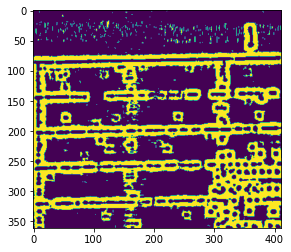

In [155]:


# getColumnShifts(clipped_im,zerotlineid)
horizontalsize=10
h,w=clipped_im.shape
ch,cw=int(h/10),int(w/55)
if ch<200 or cw<200:
    if ch<200:
        ch=200
    if cw<200:
        cw=200
selim=clipped_im[:ch,:cw]
# selim=clipped_im[:int(h/2),:int(w/5)]
horizontal = cv2.adaptiveThreshold(selim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)

# rows,cols = horizontal.shape
# # horizontalsize = 30
# horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,4))
# # horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
# horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))
selim=horizontal.astype(float)

fig=plt.figure(figsize=(16,4))
plt.imshow(horizontal)
# selim[selim<=127.0]=1
# selim[selim>127.0]=0
res=selim.sum(axis=1)
mindx=np.argmin(res)
checkval=np.mean(res)-2*np.std(res)
if checkval<0:
    checkval=np.mean(res)
idxs=np.where(res>checkval)[0]
fbreak=np.where(np.diff(idxs)>1)[0]

zerotlineid=np.mean(idxs[:fbreak[0]]).astype(int)
zerotlineid

(98115.66287059119, 23007.157926406537, 144129.97872340426)

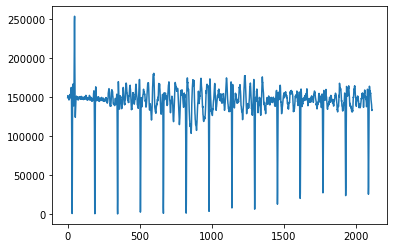

In [83]:
plt.plot(res)
checkval,np.std(res),np.mean(res)

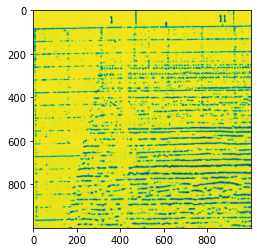

In [64]:
fig=plt.figure(figsize=(16,4))
plt.imshow(clipped_im)

In [167]:
resim.shape,start,endx
pad
np.random.sample(20,30,40)

TypeError: random_sample() takes at most 1 positional argument (3 given)

In [157]:
denom=30
pad=int(clipped_im.shape[0]/denom)
while pad<mp:
    denom-=5
    print(denom,pad,mp)
    pad=int(clipped_im.shape[0]/denom)    
    
pad,mp

(120, 60)

In [162]:
# xvals,indexes=getColumnShifts(clipped_im,zerotlineid)

mp=zerotlineid
denom=30
pad=int(clipped_im.shape[0]/denom)
while pad<mp:
    denom-=5
    print(denom,pad,mp)
    pad=int(clipped_im.shape[0]/denom) 
fpad,bpad=mp,pad

print(mp,fpad)
resim=clipped_im[mp-fpad:mp+bpad,:]

horizontal = cv2.adaptiveThreshold(resim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
rows,cols = horizontal.shape
horizontalsize=10
#     print('horizontalsize',horizontalsize)
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,1))
# horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))

resim=horizontal.astype(float)
width=5
ncols=horizontalsize
mfilter=np.vstack([np.zeros((width,ncols))-0.5,np.ones((width,ncols)),np.zeros((width,ncols))-0.5])
opencvOutput = cv2.filter2D(resim, -1, mfilter)
ffpad=3 if fpad/2 >3 else int(fpad/2 )
fbpad=3
midxs=[]
window=60
opencvOutput.shape,mp
for i in range(window,opencvOutput.shape[1],window):
#     print(i)
    try:
        start,endx=mp-ffpad,mp+fbpad
#         print(start,endx)
        if start<0:
            start=0
        poo=opencvOutput[start:endx,i-window:i]    
    #     print(i)
        idxs=np.argmin(poo,axis=0)
        nowidxs=start+idxs

        # poo=opencvOutput[mp-ffpad:mp+fbpad,i-window:i]    
        # idxs=np.argmin(poo,axis=0)
        # nowidxs=mp-ffpad+idxs
        midxs.extend(list(nowidxs))
        mp=int(np.mean(nowidxs))
    except:
        print(i, end='ndone')
poo=opencvOutput[mp-ffpad:mp+fbpad,i:]    
idxs=np.argmin(poo,axis=0)
nowidxs=mp-ffpad+idxs
midxs.extend(list(nowidxs))

76 76


In [138]:
# opencvOutput.shape
# midxs

# midxs

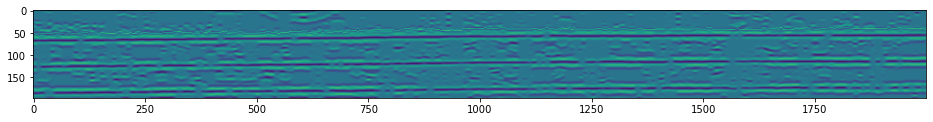

In [164]:
# indexes=[]
# for i,mi in enumerate(midxs):
#     indexes.append(np.array([mi,i]))
#     opencvOutput[mi,i]=20000
# np.array(indexes)
fig=plt.figure(figsize=(16,4))
plt.imshow(opencvOutput[:,2000:4000])

(array([ 1122.,  3008.,  7642., 18212., 38112., 74727., 18480., 11353.,
         5193.,   151.]),
 array([-1.2750000e+04, -1.0200000e+04, -7.6500000e+03, -5.1000000e+03,
        -2.5500000e+03, -1.8189894e-12,  2.5500000e+03,  5.1000000e+03,
         7.6500000e+03,  1.0200000e+04,  1.2750000e+04]),
 <BarContainer object of 10 artists>)

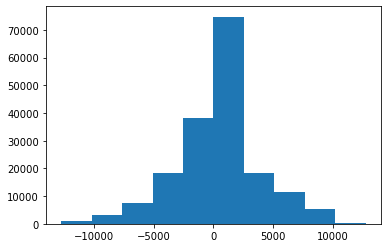

In [133]:
# opencvOutput[np.array(indexes)]
plt.hist(opencvOutput.ravel())

In [63]:

# fig=plt.figure(figsize=(16,4))
# plt.imshow(opencvOutput)
# i=10
mp=zerotlineid
start,endx=mp-ffpad,mp+fbpad
print(start,endx)
# opencvOutput[start:endx,i-window:i] 
opencvOutput[start:endx,:],opencvOutput.shape

75 81


(array([], shape=(0, 1000), dtype=float64), (66, 1000))